In [1]:
import setup
import numpy as np
import pandas as pd
from thalpy.constants import paths
from matplotlib import pyplot as plt
from thalpy import masks
from thalpy.analysis import pc, plotting, feature_extraction, fc
from thalpy import base
import nibabel as nib
import seaborn as sns
import os

/home/esorenson/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


220202-11:52:43,82 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.0


# Common Functions

## PCA

In [2]:
### PCA 
from pca import pca
from scipy import stats
from scipy.spatial import distance
from IPython.display import display, HTML

def run_pca(matrix, dir_tree, output_name, task_list, masker=None):
    os.chdir(dir_tree.analysis_dir)
    pca, loadings, correlated_loadings, explained_var = feature_extraction.compute_PCA(matrix, output_name=output_name, var_list=task_list, masker=masker)
    
    # for MDTB 
    # pca_comps[:, 1] = pca_comps[:, 1] * -1
    # loadings[:, 1] = loadings[:, 1] * -1
    # correlated_loadings[1] = correlated_loadings[1] * -1

    loadings_df = pd.DataFrame(loadings, index=task_list)
    summary_df = loadings_df.describe()
    var_df = loadings_df.var(axis=0).rename("var")
    summary_df = summary_df.append(var_df)
    display(HTML(summary_df.to_html()))
    
    return pca, loadings, explained_var

def all_comps_task_space(pca_comps, loadings, dir_tree, task_list, masker):
    os.chdir(dir_tree.analysis_dir)
    all_comps_task_space = np.empty([len(task_list), pca_comps.shape[0], 3])
    for i in range(3):

        # save PCs back into nifti image and visualize
        comp_array = pca_comps[:, i]
        print(comp_array.shape)
        img = masker.inverse_transform(comp_array)
    #     nib.save(img, f"pca_mdtb_pc{index}.nii")
        plotting.plot_thal(img)
        print(pca_comps.shape)

        # save each pc in task space
        pc_task_space = np.dot(np.swapaxes(loadings.T, 0, 1)[:, i, np.newaxis], np.swapaxes(pca_comps, 0,1)[np.newaxis, i, :])
        #     pc_task_space_imgs = masker.inverse_transform(pc_task_space)
        # nib.save(pc_task_space_imgs, f"pca_task_space_pc{i}.nii")
        print(pc_task_space.shape)
        print(all_comps_task_space.shape)
        all_comps_task_space[:, :, i] = pc_task_space

    #     for task in range(len(task_list)):
    #         img = masker.inverse_transform(pc_task_space[task, :])
    #         plotting.plot_thal(img)
    #         plt.show()
    
    return all_comps_task_space
    
# avg component
def sum_comps(pca_comps, explained_var_list, masker):
    summed_comps = np.empty([2227])
    print(pca_comps)
    print(explained_var_list)
    
    for i in range(pca_comps.shape[1]):
        weighted_comp = np.abs(pca_comps[:, i]) * explained_var_list[i]
        summed_comps += weighted_comp
    
    plotting.plot_thal(masker.inverse_transform(summed_comps))
    
    return summed_comps


## Clustering

In [3]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogrammasks

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def hier_cluster(task_matrix, n_clusters=None):
    if n_clusters is None:
        distance_threshold = 0
    else:
        distance_threshold = None
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters)
    cluster = model.fit(np.mean(task_matrix, axis=2).swapaxes(0, 1))
    if distance_threshold is not None:
        plot_dendrogram(model)
    return cluster



In [4]:
from sklearn.cluster import KMeans
VOXELS = 2227

def cluster_sub(sub_matrix, k):
    sub_correlation_matrix = np.corrcoef(sub_matrix)
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(sub_correlation_matrix)

    # plus 1 is just for plotting purposes, labels with 0 show up not having color
    return model.labels_ + 1, model

def consensus_cluster(task_matrix, masker, output_dir, label=""):
    # consensus clustering

    for k_cluster in range(2, 8):
        consensus_matrix = np.empty([VOXELS, VOXELS, task_matrix.shape[-1]])
        for i in range(task_matrix.shape[-1]):
            sub_cluster, model = cluster_sub(task_matrix[:, :, i], k_cluster)
            coassignment_matrix = np.empty([VOXELS, VOXELS])
            for j in range(VOXELS):
                for k in range(VOXELS):
                    if sub_cluster[j] == sub_cluster[k]:
                        coassignment_matrix[j][k] = 1
                    else:
                          consensus_matrix[:, :, i] = coassignment_matrix

        mean_matrix = consensus_matrix.mean(2)
        final_consensus_cluster, model = cluster_sub(mean_matrix, k_cluster)
        final_consensus_cluster = masker.inverse_transform(final_consensus_cluster)
        nib.save(final_consensus_cluster, output_dir + f"consensus_cluter_{label}_{k_cluster}.nii")
        plotting.plot_thal(final_consensus_cluster)

def plot_clusters(sub_matrix):
    ks = range(2, 10)
    inertias = []
    for k in ks:
        cluster_atlas, model = cluster_sub(sub_matrix, k)
        plotting.plot_roi(cluster_atlas, cmap=plt.cm.get_cmap("tab10"))
        plotting.show()

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, "-o", color="black")
    plt.xlabel("number of clusters, k")
    plt.ylabel("inertia")
    plt.xticks(ks)
    plt.show()

## Activity Flow

In [5]:
# Indiviuals
# rs_data doesn't match up -- not all subjects have rs data.
def corr_sub(rs, thal_betas, cortical_betas, task_list, rs_indexer=None):
    if rs_indexer:
        rs_indexer = rs_indexer
    else:
        rs_indexer = np.s_[:, :]
        
    sub_cor_array = np.zeros([len(task_list), thal_betas.shape[2]]) 
    
    array_index = 0 
    for rs_index in range(len(rs.fc_subjects)):
        fc_subject = rs.fc_subjects[rs_index]
        if fc_subject is None:
            continue
        try:
            beta_index = subjects.to_subargs_list().index(fc_subject.name)
        except:
            continue
        
        sub_rs = rs.fc_subjects[rs_index].seed_to_voxel_correlations[rs_indexer]
        predicted_corticals = np.dot(np.swapaxes(thal_betas[:, :, beta_index], 0, 1), sub_rs)
        sub_cortical_betas = np.swapaxes(cortical_betas[:, :, beta_index], 0, 1)
        for i, task in enumerate(task_list):
            corr = np.corrcoef(predicted_corticals[i, :], sub_cortical_betas[i, :])[0, 1]
            sub_cor_array[i, array_index] = corr
            
            
        array_index += 1
    
    return sub_cor_array
# Averaged across subjects
def corr_avg(rs, thal_betas, cortical_betas, task_list, rs_indexer=None):
    if rs_indexer:
        rs_indexer = rs_indexer
    else:
        rs_indexer = np.s_[:, :, :]
        
    avg_predicted_corticals = np.dot(np.swapaxes(thal_betas, 0, 1), np.mean(rs.data[rs_indexer], axis=2))
    avg_cortical_betas = np.swapaxes(np.mean(cortical_betas, axis=2), 0, 1)
    cor_array = np.empty([len(task_list)])
    for i, task in enumerate(task_list):
        cor = np.corrcoef(avg_predicted_corticals[i, :], avg_cortical_betas[i, :])[0, 1]
        cor_array[i] = cor

    return cor_array

# Null Models
def null_corr(k, thal_betas, cortical_betas, rs, task_list, sub_rs_indexer=None, avg_rs_indexer=None):
    if sub_rs_indexer:
        sub_rs_indexer = sub_rs_indexer
    else:
        sub_rs_indexer = np.s_[:, :]
        
    if avg_rs_indexer:
        avg_rs_indexer = avg_rs_indexer
    else:
        avg_rs_indexer = np.s_[:, :, :]
        
    null_corr_array = np.empty([k, len(task_list)])
    null_sub_corr_array = np.empty([k, len(task_list), thal_betas.shape[2]])
    for i in np.arange(k):
        rand_avg_thal = np.nanmean(thal_betas, axis=2)
        rand_sub_thal = np.copy(thal_betas)
        for j in np.arange(len(task_list)):
            rand_avg_thal[:, j] = np.random.permutation(rand_avg_thal[:, j])
            for k in np.arange(thal_betas.shape[2]):
                rand_sub_thal[:, j, k] = np.random.permutation(rand_sub_thal[:, j, k])
        null_corr_array[i, :] = corr_avg(rs, rand_avg_thal, cortical_betas, task_list, rs_indexer=avg_rs_indexer)
        null_sub_corr_array[i, :, :] = corr_sub(rs, rand_sub_thal, cortical_betas, task_list, rs_indexer=sub_rs_indexer)
    
    return null_corr_array, null_sub_corr_array

# threshold high variance summed voxels
def threshold_matrix(beta_matrix, summed_pca, low_threshold, top_threshold):
    voxels_to_keep = np.where(summed_pca > np.percentile(summed_pca, top_threshold), 1, 0) + np.where(summed_pca < np.percentile(summed_pca, low_threshold), 1, 0)
    
    func = lambda x: x * voxels_to_keep
    threshold_matrix = np.apply_along_axis(func, 0, beta_matrix)
    return threshold_matrix

# MDTB

## Setup Data

In [6]:
from thalpy.analysis import glm

MDTB_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/"
MDTB_DIR_TREE = base.DirectoryTree(MDTB_DIR)
MDTB_ANALYSIS_DIR = MDTB_DIR + 'analysis/'

stim_config_df = pd.read_csv(MDTB_DIR + paths.DECONVOLVE_DIR + paths.STIM_CONFIG)
MDTB_CONDITIONS = stim_config_df["Stim Label"].tolist()

MDTB_TASKS = list(set(stim_config_df["Group"].to_list()))

mdtb_subjects = base.get_subjects(MDTB_DIR_TREE.deconvolve_dir, MDTB_DIR_TREE)

img = nib.load(MDTB_DIR_TREE.fmriprep_dir + "sub-02/ses-a1/func/sub-02_ses-a1_task-a_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
mdtb_masker = masks.binary_masker(masks.MOREL_PATH)
mdtb_masker.fit(img)


# mdtb_task_betas = glm.load_brik(mdtb_subjects, mdtb_masker, "FIRmodel_MNI_stats_block+tlrc.BRIK", MDTB_TASKS, zscore=True, kind="beta")
# np.save(MDTB_ANALYSIS_DIR + 'mdtb_task_zscored.npy', mdtb_task_betas)

# mdtb_conditions_betas = glm.load_brik(mdtb_subjects, mdtb_masker, "FIRmodel_MNI_stats_norest+tlrc.BRIK", MDTB_CONDITIONS, zscore=True, kind="beta")
# np.save(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy', mdtb_conditions_betas)

# schaefer_masker = masks.roi_masker(masks.SCHAEFER_400_7N_PATH)
# zscored_cort_matrix = glm.load_brik(mdtb_subjects, schaefer_masker, "FIRmodel_MNI_stats_block+tlrc.BRIK", MDTB_TASKS, zscore=True, kind="beta")
# np.save(MDTB_ANALYSIS_DIR + "beta_cortical.npy", zscored_cort_matrix) 

# schaefer_masker_900 = masks.roi_masker(masks.SCHAEFER_900_7N_PATH)
# beta_matrix_900 = glm.load_brik(mdtb_subjects, schaefer_masker_900, "FIRmodel_MNI_stats_norest+tlrc.BRIK", MDTB_TASKS, zscore=True, kind="beta")
# np.save(MDTB_DIR_TREE.analysis_dir + "beta_corticals_900.npy", beta_matrix_900)

mdtb_task_betas = np.load(MDTB_ANALYSIS_DIR + 'mdtb_task_zscored.npy')
mdtb_conditions_betas = np.load(MDTB_ANALYSIS_DIR + 'mdtb_zscored.npy')

## FC

In [7]:
# FC MDTB on task residuals

# from thalpy import base, masks
# from thalpy.analysis import fc
# MDTB_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/"
# MDTB_DIR_TREE = base.DirectoryTree(MDTB_DIR)
# mdtb_subjects = base.get_subjects(MDTB_DIR_TREE.deconvolve_dir, MDTB_DIR_TREE)

# mdtb_masker = masks.binary_masker(masks.MOREL_PATH)
# schaefer_masker = masks.roi_masker(masks.SCHAEFER_400_7N_PATH)
# mdtb_subjects = base.get_subjects(MDTB_DIR_TREE.deconvolve_dir, MDTB_DIR_TREE)


# fc_residuals = fc.FcData(
#     MDTB_DIR_TREE.dataset_dir,
#     mdtb_masker,
#     schaefer_masker,
#     "fc_task_residuals",
#     subjects=mdtb_subjects,
#     censor=True,
#     is_denoise=False,
#     bold_dir=MDTB_DIR_TREE.deconvolve_dir,
#     bold_WC="*FIRmodel_errts_block.nii.gz",

# )
# fc_residuals.calc_fc(cores=4)

## Clustering of Tasks

0: VisualSearch
1: LandscapeMovie
2: WordPrediction
3: MotorImagery
4: NatureMovie
5: Go/NoGo
6: SpatialImagery
7: Interval
8: ResponseAlternativesMotor
9: TheoryOfMind
10: ObjectViewing
11: Verbal2Back
12: ActionObservation
13: AnimatedMovie
14: Stroop
15: Math
16: IAPSaffective
17: ObjectNBackTask
18: Language
19: MentalRotation
20: SpatialMap
21: Motor
22: IAPSemotion
23: BiologicalMotion
24: Rules
k: 0  group: ['SpatialImagery', 'Interval', 'ObjectViewing', 'ActionObservation', 'SpatialMap', 'IAPSemotion', 'Rules']
k: 1  group: ['Go/NoGo', 'ResponseAlternativesMotor', 'Stroop', 'MentalRotation', 'Motor', 'BiologicalMotion']
k: 2  group: ['LandscapeMovie', 'WordPrediction', 'MotorImagery', 'Verbal2Back', 'IAPSaffective', 'ObjectNBackTask']
k: 3  group: ['NatureMovie', 'TheoryOfMind', 'Math']
k: 4  group: ['Language']
k: 5  group: ['VisualSearch', 'AnimatedMovie']


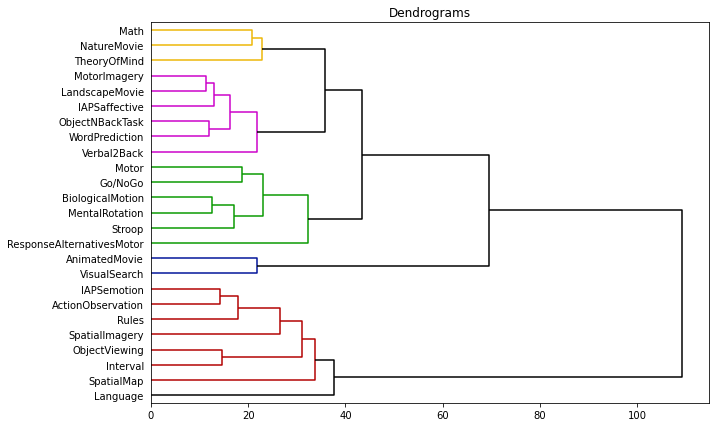

In [8]:
from thalpy.constants import paths
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
shc.set_link_color_palette(['#b30000','#001299', '#089900', '#cc00c9', '#edb705']) 
dend = shc.dendrogram(shc.linkage(np.swapaxes(np.mean(mdtb_task_betas, axis=2), 0, 1), method='ward'), color_threshold=35, above_threshold_color='black', orientation="right", labels=MDTB_TASKS)

conditions_cluster = hier_cluster(mdtb_task_betas, n_clusters=6)

# dendrogram(conditions_cluster)
for i, item in enumerate(MDTB_TASKS):
    print(f"{i}: {item}")

for k in np.arange(len(np.unique(conditions_cluster.labels_))):
    group = [condition for i, condition in enumerate(MDTB_TASKS) if k == conditions_cluster.labels_[i]]
    print(f'k: {k}  group: {group}')

## PC

/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(
/home/esorenson/.local/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


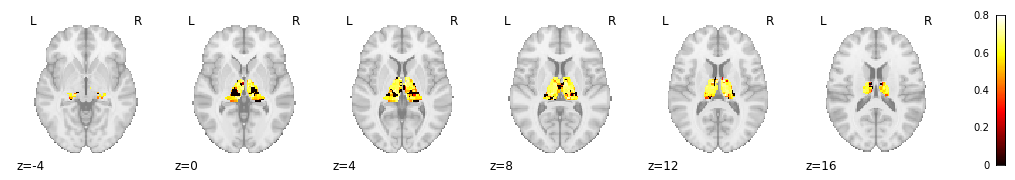

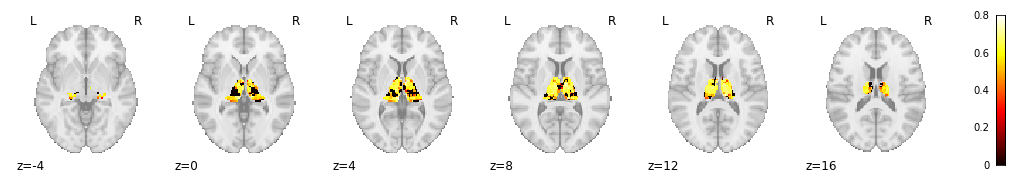

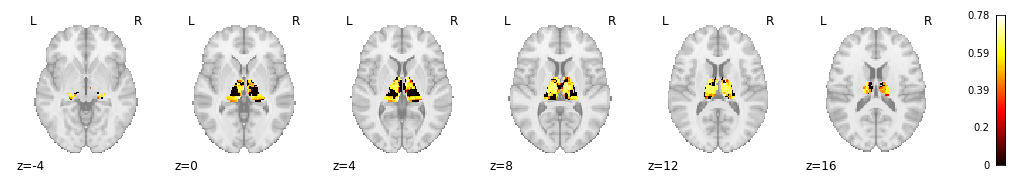

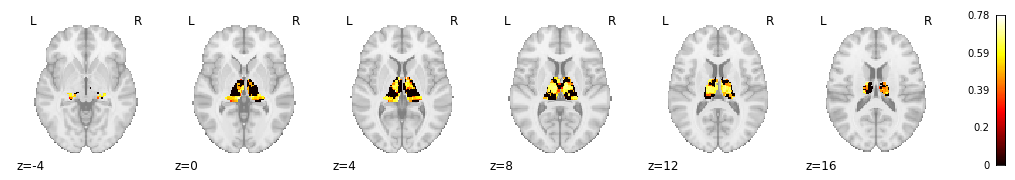

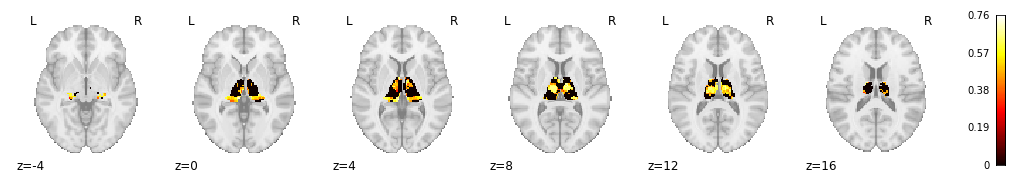

In [9]:
thresholds = [70, 75, 80, 85, 90]
pc_matrix = pc.pc_subject(np.mean(mdtb_task_betas, axis=2), conditions_cluster.labels_, thresholds=thresholds)
pc_matrix = np.where(np.isnan(pc_matrix), 0.001, pc_matrix)
pc_matrix = np.where(pc_matrix <= 0, 0.001, pc_matrix)

for i, threshold in enumerate(thresholds):
    pc_img = mdtb_masker.inverse_transform(pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)
    nib.save(pc_img, MDTB_DIR_TREE.analysis_dir + f"pc_{threshold}.nii")

## PCA

Explained variance:
[0.49389824 0.22473486 0.07332646 0.05120922 0.0340284  0.02312069
 0.01541121 0.01349145 0.01279168 0.00903912]


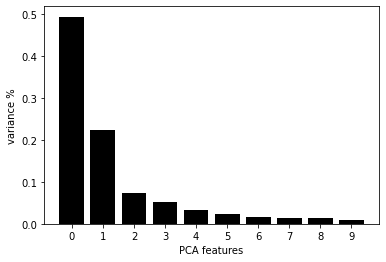

(2227,)
(2227, 10)
(25, 2227)
(25, 2227, 3)
(2227,)
(2227, 10)
(25, 2227)
(25, 2227, 3)
(2227,)
(2227, 10)
(25, 2227)
(25, 2227, 3)


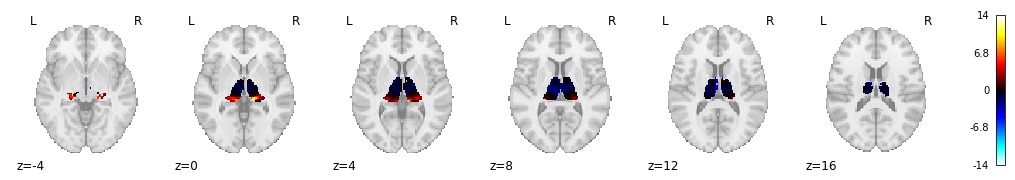

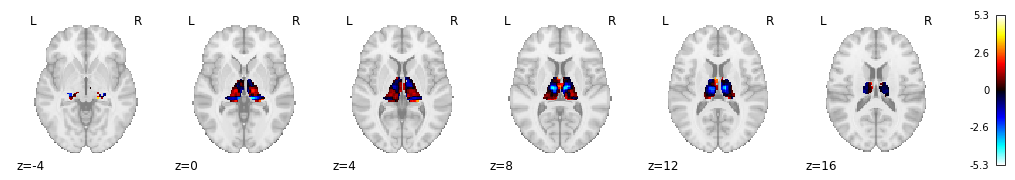

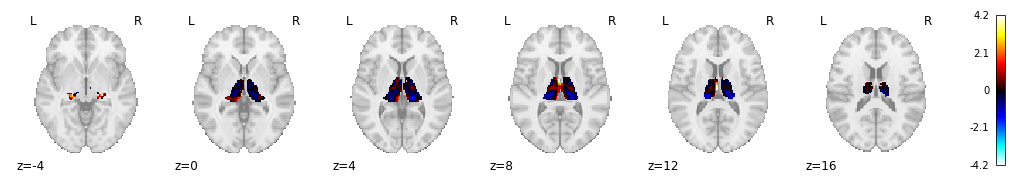

In [10]:
mdtb_pca_comps, mdtb_loadings, mdtb_explained_var = run_pca(np.mean(mdtb_task_betas, axis=2), MDTB_DIR_TREE, 'mdtb_pca', MDTB_TASKS)

mdtb_all_comps_task_space = all_comps_task_space(mdtb_pca_comps, mdtb_loadings, MDTB_DIR_TREE, MDTB_TASKS, mdtb_masker)

In [11]:
### PCA comps correlation to PC

pc_rs = nib.load('/data/backed_up/shared/ROIs/PC.4floor.nii.gz')
pc_masked = mdtb_masker.transform(pc_rs)
for comp in np.arange(mdtb_pca_comps.shape[1]):
    f_corr = np.corrcoef(pc_matrix[:, 2], mdtb_pca_comps[:, comp])[0, 1] 
    rs_corr = np.corrcoef(pc_masked, mdtb_pca_comps[:, comp])[0, 1]
    print(comp)
    print(f_corr)
    print(rs_corr)

0
0.03484429890204622
-0.24458866983401123
1
-0.630208979961471
-0.254806230691395
2
0.2257274681182466
0.1484479657611066
3
0.02512460045002774
0.3028818001818714
4
-0.000617685041504353
0.14829454578621684
5
-0.12121863516776836
0.01865219475930036
6
0.037975962004355296
0.1005404588369709
7
0.04521272664273035
-0.10518919034320508
8
0.0793242691389415
-0.08619204598202944
9
0.03855773138794084
0.04808458627710124


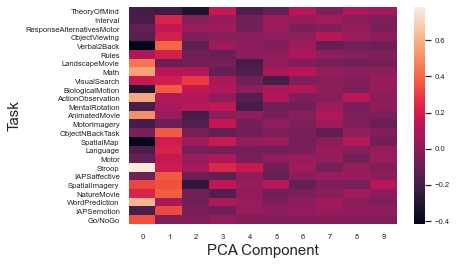

In [12]:
### Loadings Heatmap

import seaborn as sns 

loadings_df = pd.read_csv('/mnt/nfs/lss/lss_kahwang_hpc/data/MDTB/analysis/pca_mdtb_task_correlated_loadings.csv').set_index('Task')
loadings_df["1"] = loadings_df["1"] * -1
sns.set(font_scale=0.7)
ax = sns.heatmap(loadings_df, xticklabels=True, yticklabels=True,)
plt.xlabel('PCA Component', fontsize=15)
plt.ylabel('Task', fontsize=15)

plt.savefig(MDTB_ANALYSIS_DIR + 'pca_heatmap.png', transparent=True)
plt.show()

[[ 1.44091039e+00  2.24232333e-01 -2.23794656e-01 ... -3.27491877e-01
  -7.12588557e-04 -9.13833428e-03]
 [ 1.64295801e+00 -3.23975781e-01 -3.22156439e-01 ... -2.83976748e-01
   7.18249138e-02  1.89186661e-02]
 [ 1.05367230e+00  1.01480698e+00  6.94751071e-02 ...  2.36263681e-03
  -1.42444863e-02  3.47434208e-01]
 ...
 [ 2.27183497e+00 -2.95456060e-01  7.24140185e-01 ... -2.61974285e-01
  -3.39866236e-01  2.86789839e-01]
 [ 2.52966964e+00 -1.24652427e+00  8.09317171e-01 ... -1.46766637e-01
  -3.34345835e-01 -1.24381699e-01]
 [ 2.33952934e+00 -1.54387114e+00  6.45481835e-01 ... -2.46007096e-01
  -1.16926842e-02 -4.09627047e-02]]
[0.49389824 0.22473486 0.07332646 0.05120922 0.0340284  0.02312069
 0.01541121 0.01349145 0.01279168 0.00903912]


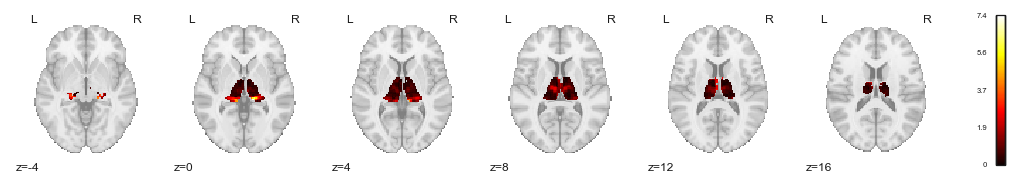

In [13]:
sum_mdtb = sum_comps(mdtb_pca_comps, mdtb_explained_var, mdtb_masker)


## Activity Flow

In [14]:
rs = fc.load(MDTB_ANALYSIS_DIR + "fc_task_residuals.p")
NUM_RS_SUB = len([x for x in rs.fc_subjects if x is not None])
cortical_betas = np.load(MDTB_ANALYSIS_DIR + "beta_cortical.npy")
subjects = base.get_subjects(MDTB_DIR_TREE.deconvolve_dir, MDTB_DIR_TREE)

sub_cor_array = corr_sub(rs, mdtb_task_betas, cortical_betas, MDTB_TASKS)

avg_cor_array = corr_avg(rs, np.mean(mdtb_task_betas, axis=2), cortical_betas, MDTB_TASKS)

# null 
null_corr_array, null_sub_corr_array = null_corr(100, mdtb_task_betas, cortical_betas, rs, MDTB_TASKS)

# evoked response to 1
sub_evoked_1 = corr_sub(rs, np.ones(mdtb_task_betas.shape), cortical_betas, MDTB_TASKS)
avg_evoked_1 = corr_avg(rs, np.ones([mdtb_task_betas.shape[0], mdtb_task_betas.shape[1]]), cortical_betas, MDTB_TASKS)

# pca comps
comps_task_space_corr = np.zeros([len(MDTB_TASKS), 3])
for i in np.arange(3):
    comps_task_space_corr[:, i] = corr_avg(rs, np.swapaxes(mdtb_all_comps_task_space[:, :, i], 0 ,1), cortical_betas, MDTB_TASKS)


In [15]:
sub_cor_array_80 = corr_sub(rs, threshold_matrix(mdtb_task_betas, sum_mdtb, 80, 100), cortical_betas, MDTB_TASKS)
sub_cor_array_60 = corr_sub(rs, threshold_matrix(mdtb_task_betas, sum_mdtb, 60, 80), cortical_betas, MDTB_TASKS)
sub_cor_array_40 = corr_sub(rs, threshold_matrix(mdtb_task_betas, sum_mdtb, 40, 60), cortical_betas, MDTB_TASKS)
sub_cor_array_20 = corr_sub(rs, threshold_matrix(mdtb_task_betas, sum_mdtb, 20, 40), cortical_betas, MDTB_TASKS)
sub_cor_array_0 = corr_sub(rs, threshold_matrix(mdtb_task_betas, sum_mdtb, 0, 20), cortical_betas, MDTB_TASKS)



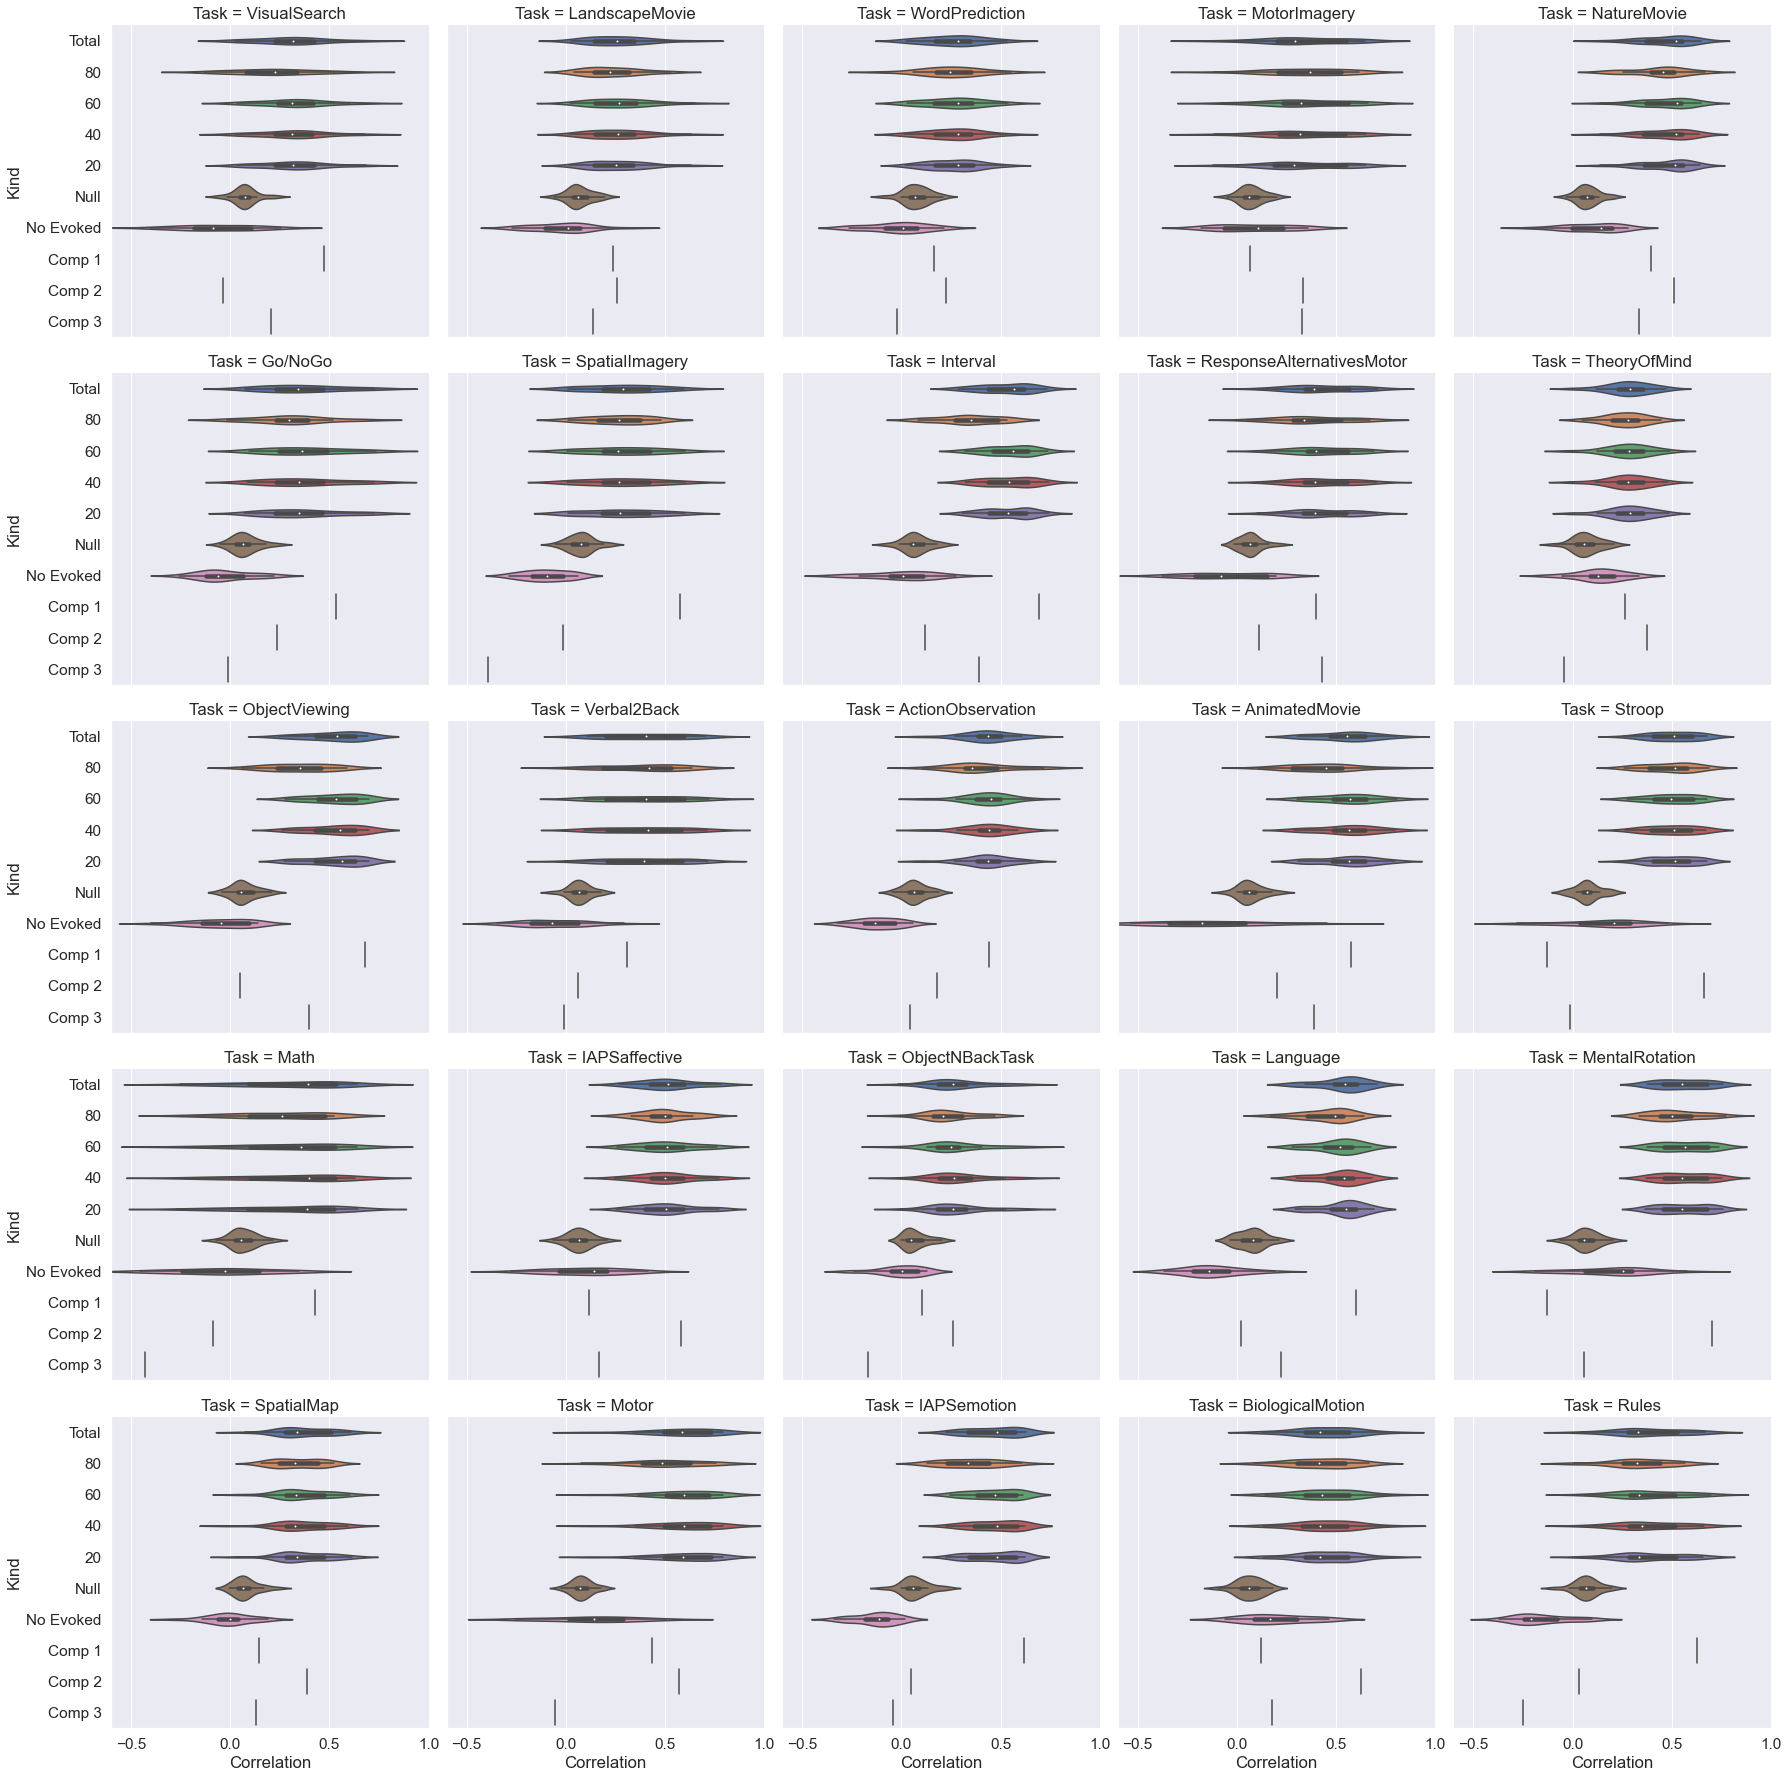

In [16]:
# subject correlations
df_data = []
for i in range(len(MDTB_TASKS)):
    for j in range(sub_cor_array.shape[1]):
        df_data.append([j, MDTB_TASKS[i], 'Total', sub_cor_array[i, j]])
        df_data.append([j, MDTB_TASKS[i], '80', sub_cor_array_80[i, j]])
        df_data.append([j, MDTB_TASKS[i], '60', sub_cor_array_60[i, j]])
        df_data.append([j, MDTB_TASKS[i], '40', sub_cor_array_40[i, j]])
        df_data.append([j, MDTB_TASKS[i], '20', sub_cor_array_20[i, j]])
        df_data.append([j, MDTB_TASKS[i], '20', sub_cor_array_0[i, j]])
        df_data.append([ j, MDTB_TASKS[i], 'Null', np.mean(null_sub_corr_array[i, j])])
        df_data.append([ j, MDTB_TASKS[i], 'No Evoked', sub_evoked_1[i, j]])
    df_data.append([ 'Avg', MDTB_TASKS[i], 'Comp 1', comps_task_space_corr[i, 0]])
    df_data.append([ 'Avg', MDTB_TASKS[i], 'Comp 2', comps_task_space_corr[i, 1]])
    df_data.append([ 'Avg', MDTB_TASKS[i], 'Comp 3', comps_task_space_corr[i, 2]])

df_activity_flow = pd.DataFrame(df_data, columns=['Subject', 'Task', 'Kind', 'Correlation'])
df_activity_flow.to_pickle(MDTB_DIR_TREE.analysis_dir + "mdtb_activity_flow_dataframe.p")

sns.set(font_scale=1.4)
fig = sns.catplot(kind='violin', orient="h", data=df_activity_flow, x='Correlation', y='Kind', col="Task", col_wrap=5)
plt.xlim([-0.6, 1])
plt.xticks([-0.5, 0, .50, 1])

sub_corr_df = pd.DataFrame(np.swapaxes(sub_cor_array, 0, 1), columns=MDTB_TASKS)
sub_corr_stats = sub_corr_df.describe()
total_sub_corr_df = pd.DataFrame(sub_cor_array.flatten())
sub_corr_stats['total'] = total_sub_corr_df.describe()
display(HTML(sub_corr_stats.to_html()))


In [17]:
# new activity flow

# take top 5 and bottom 5 -> run activity flow
pc_schaeffer_img = nib.load(MDTB_DIR_TREE.analysis_dir + "Schaeffer900_MGH_PC.nii")
schaeffer_900_masker = masks.roi_masker(masks.SCHAEFER_900_7N_PATH)
pc_matrix = schaeffer_900_masker.fit_transform(pc_schaeffer_img)

top_5_idx = np.argsort(pc_matrix[0, :])[:5]
bottom_5_idx = np.argsort(pc_matrix[0, :])[-5:]
combined_idx = list(np.concatenate((top_5_idx, bottom_5_idx)))

rs = fc.load(MDTB_ANALYSIS_DIR + "fc_task_residuals_900.p")
NUM_RS_SUB = len([x for x in rs.fc_subjects if x is not None])
cortical_betas = np.load(MDTB_ANALYSIS_DIR + "beta_corticals_900.npy")
subjects = base.get_subjects(MDTB_DIR_TREE.deconvolve_dir, MDTB_DIR_TREE)

df_rows = []
for roi in range(900):
    sub_rs_indexer=np.s_[np.newaxis, roi, :]
    avg_rs_indexer=np.s_[np.newaxis, roi, :, :]
    cortical_betas_roi = cortical_betas[np.newaxis, roi, :, :]
    
    sub_cor_array = corr_sub(rs, cortical_betas_roi, cortical_betas, MDTB_TASKS, rs_indexer=sub_rs_indexer)
    avg_cor_array = corr_avg(rs, np.mean(cortical_betas_roi, axis=2), cortical_betas, MDTB_TASKS, rs_indexer=avg_rs_indexer)

    # null 
    null_corr_array, null_sub_corr_array = null_corr(100, cortical_betas_roi, cortical_betas, rs, MDTB_TASKS, sub_rs_indexer=sub_rs_indexer, avg_rs_indexer=avg_rs_indexer)
    
    # evoked response to 1
    sub_evoked_1 = corr_sub(rs, np.ones(cortical_betas_roi.shape), cortical_betas, MDTB_TASKS, rs_indexer=sub_rs_indexer)
    avg_evoked_1 = corr_avg(rs, np.ones([cortical_betas_roi.shape[0], cortical_betas_roi.shape[1]]), cortical_betas, MDTB_TASKS, rs_indexer=avg_rs_indexer)

    for i in range(len(MDTB_TASKS)):
        for j in range(sub_cor_array.shape[1]):
            df_rows.append([roi, j, MDTB_TASKS[i], 'Total', sub_cor_array[i, j]])
            df_rows.append([roi, j, MDTB_TASKS[i], 'Null', np.nanmean(null_sub_corr_array[:, i, j])])
            df_rows.append([roi, j, MDTB_TASKS[i], 'No Evoked', sub_evoked_1[i, j]])
    
    
columns = ['Roi', 'Subject', 'Task', 'Kind', 'Correlation']
master_df = pd.DataFrame(df_rows, columns=columns)   
master_df.to_pickle(MDTB_DIR_TREE.analysis_dir + "mdtb_activity_flow_pc_rois.p")


<ipython-input-17-1ea43ea29b49>:36: RuntimeWarning: Mean of empty slice
  df_rows.append([roi, j, MDTB_TASKS[i], 'Null', np.nanmean(null_sub_corr_array[:, i, j])])


# Tomoya

## Setup Data

In [ ]:
from thalpy.analysis import glm
from thalpy import base, masks

TOMOYA_DIR_TREE = base.DirectoryTree('/mnt/nfs/lss/lss_kahwang_hpc/data/Tomoya')
subjects = base.get_subjects(TOMOYA_DIR_TREE.deconvolve_dir, TOMOYA_DIR_TREE)
stim_config_df = pd.read_csv(TOMOYA_DIR_TREE.deconvolve_dir + paths.STIM_CONFIG)
TOMOYA_TASKS = stim_config_df["Stim Label"].tolist()
tomoya_masker = masks.binary_masker(masks.MOREL_PATH)

tomoya_masker.fit(nib.load('/mnt/nfs/lss/lss_kahwang_hpc/data/Tomoya/3dDeconvolve/sub-01/FIRmodel_MNI_stats.nii'))
# tomoya_beta_matrix = glm.load_brik(subjects, masker, 'FIRmodel_MNI_stats.nii', 2227, TOMOYA_TASKS)
# np.save('tomoya_beta.npy', tomoya_beta_matrix)

schaefer_mask = masks.roi_masker(masks.SCHAEFER_400_7N_PATH)
schaefer_mask.fit(nib.load('/mnt/nfs/lss/lss_kahwang_hpc/data/Tomoya/3dDeconvolve/sub-01/FIRmodel_MNI_stats.nii'))
# tomoya_cortical_betas = glm.load_brik(subjects, schaefer_mask, "FIRmodel_MNI_stats.nii", 400, TOMOYA_TASKS)
# np.save(TOMOYA_DIR_TREE.analysis_dir + "beta_corticals.npy", tomoya_cortical_betas)

# fc_data = fc.FcData(
#     TOMOYA_DIR_TREE.dataset_dir,
#     masker,
#     schaefer_mask,
#     "fc_task_residuals",
#     subjects=subjects,
#     censor=False,
#     is_denoise=False,
#     bold_dir=TOMOYA_DIR_TREE.deconvolve_dir,
#     bold_WC="*FIRmodel_errts.nii.gz",
#     cores=8,
# )
# fc_data.calc_fc()
tomoya_rs = fc.load(TOMOYA_DIR_TREE.analysis_dir + "fc_task_residuals.p")

tomoya_beta_matrix = np.load(os.path.join(TOMOYA_DIR_TREE.analysis_dir, 'tomoya_beta.npy'))
tomoya_cortical_betas = np.load(os.path.join(TOMOYA_DIR_TREE.analysis_dir, 'beta_corticals.npy'))

## PCA

Explained variance:
[0.24283326 0.13583435 0.1266729  0.04636843 0.03969473 0.03290696
 0.02337343 0.02231827 0.0147305  0.01280407 0.01019627 0.0096635
 0.00871992 0.0083116  0.00783355 0.00729664 0.00707801 0.00694758
 0.0066828  0.00632861 0.00603776 0.00576743 0.00572225 0.00564436
 0.0055566  0.00528144 0.00519032 0.00510793 0.00487782 0.00473018
 0.00469584 0.00440235 0.00427931 0.00420174 0.00414602 0.0041043
 0.00400172 0.00395875 0.00373227 0.00360605 0.00346723 0.00344158
 0.00338352 0.00328806 0.00326343 0.00323437 0.0031758  0.00314896
 0.0030706  0.00296629 0.00295462 0.00283488 0.00280826 0.00271394
 0.00265728 0.00261975 0.00252554 0.00248447 0.00245441 0.00241614
 0.00236296 0.00231401 0.0022496  0.00224168 0.00219873 0.00215903
 0.00212172 0.00210136 0.00206439]


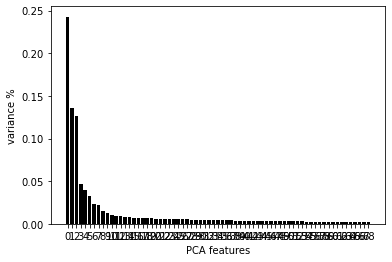

/home/esorenson/.local/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


(2227,)
(2227, 69)
(104, 2227)
(104, 2227, 3)
(2227,)
(2227, 69)
(104, 2227)
(104, 2227, 3)
(2227,)
(2227, 69)
(104, 2227)
(104, 2227, 3)


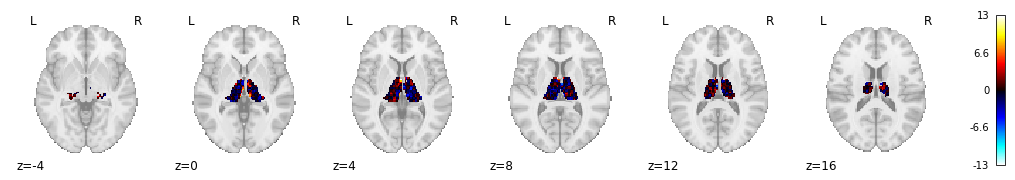

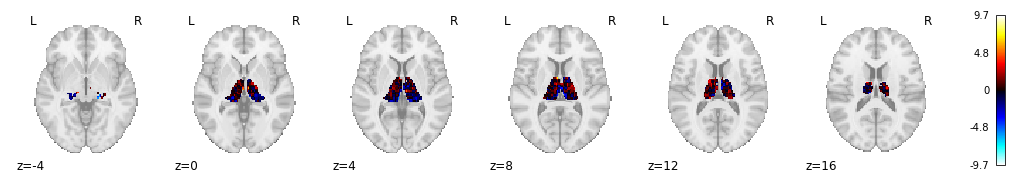

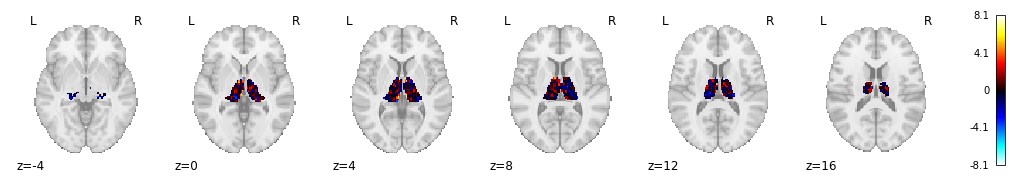

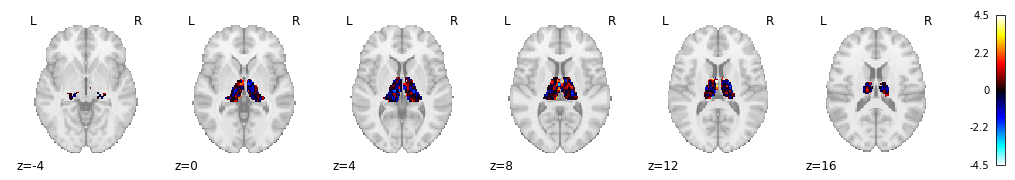

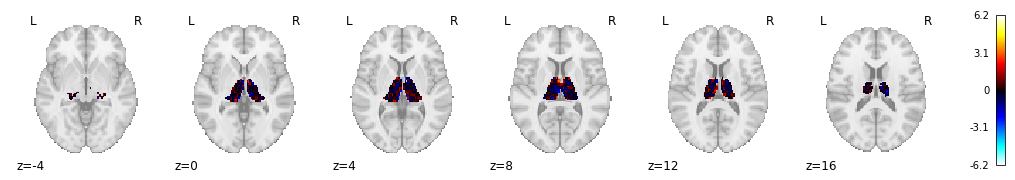

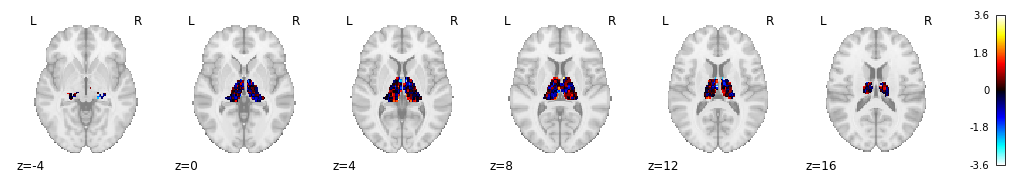

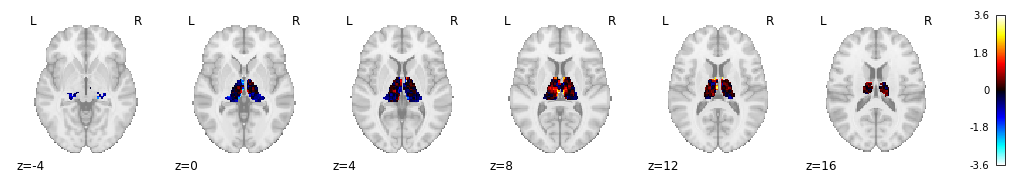

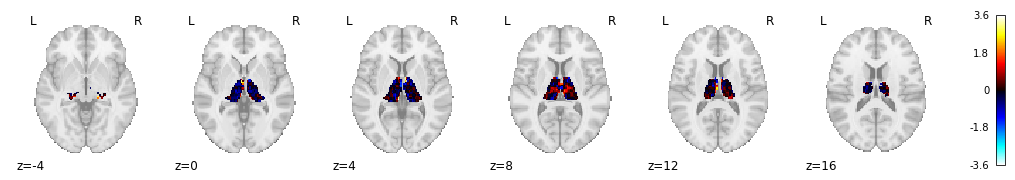

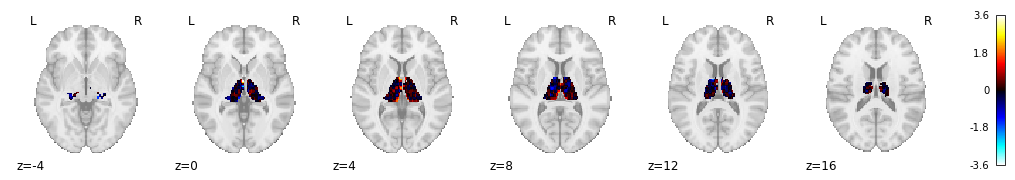

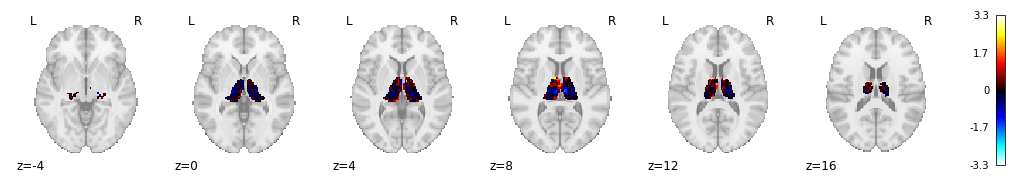

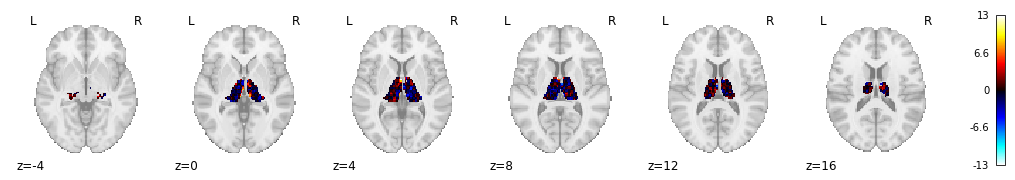

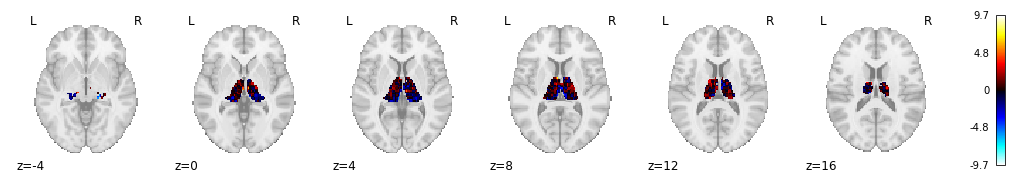

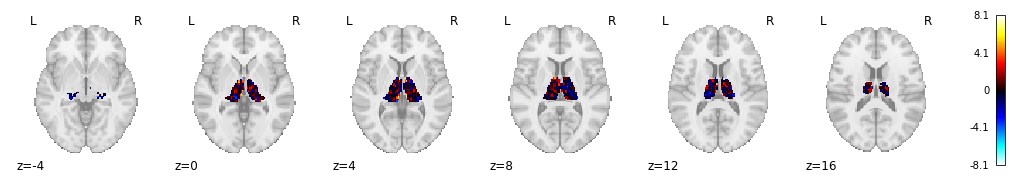

In [ ]:
# PCA on Tomoya
averaged_sub_beta_tomoya = np.mean(tomoya_beta_matrix, axis=2)
tomoya_pca_comps, tomoya_loadings, tomoya_explained_var = run_pca(averaged_sub_beta_tomoya, TOMOYA_DIR_TREE, 'tomoya_pca', TOMOYA_TASKS, masker=tomoya_masker)
tomoya_task_space = all_comps_task_space(tomoya_pca_comps, tomoya_loadings, TOMOYA_DIR_TREE, TOMOYA_TASKS, tomoya_masker) 

/home/esorenson/.local/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


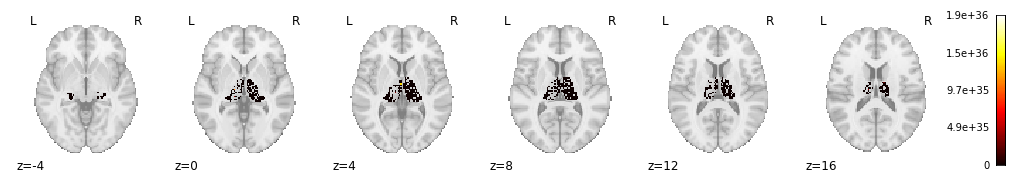

In [ ]:
sum_tomoya = sum_comps(tomoya_pca_comps, tomoya_explained_var, tomoya_masker)

## PC

/mnt/nfs/lss/lss_kahwang_hpc/scripts/thalpy/analysis/pc.py:84: RuntimeWarning: invalid value encountered in true_divide
  np.sum(


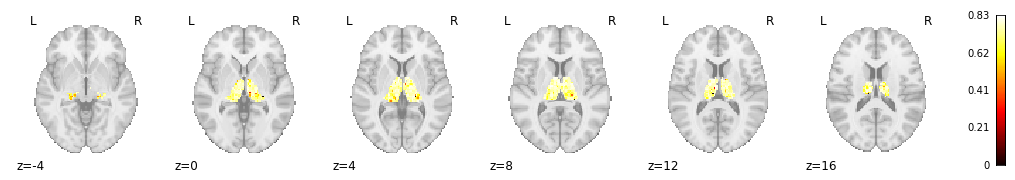

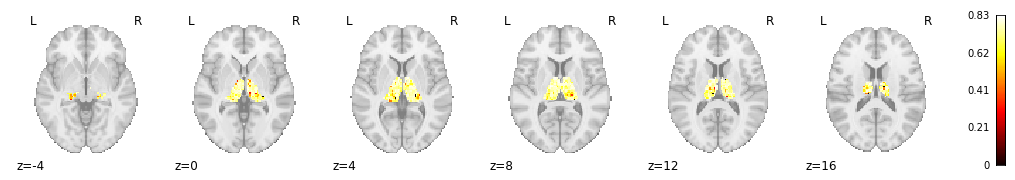

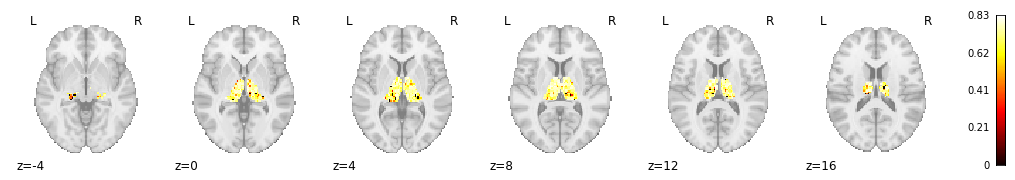

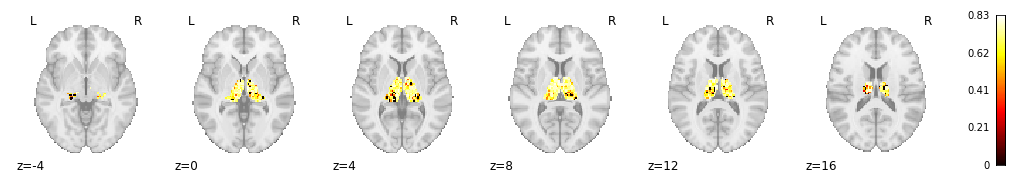

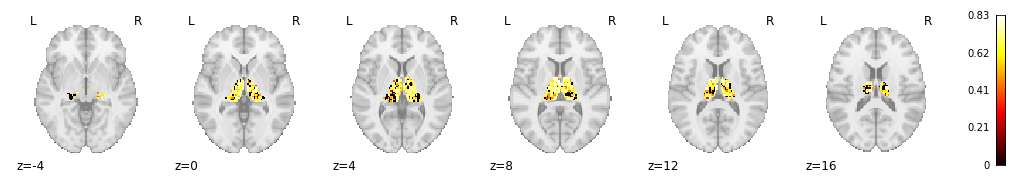

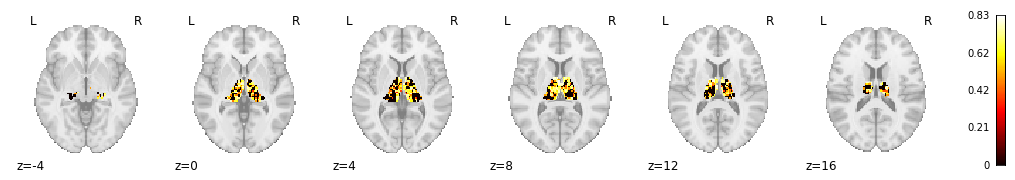

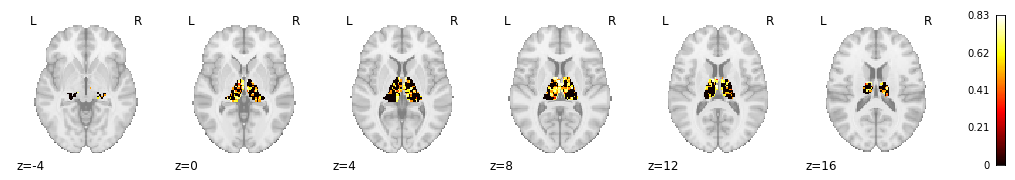

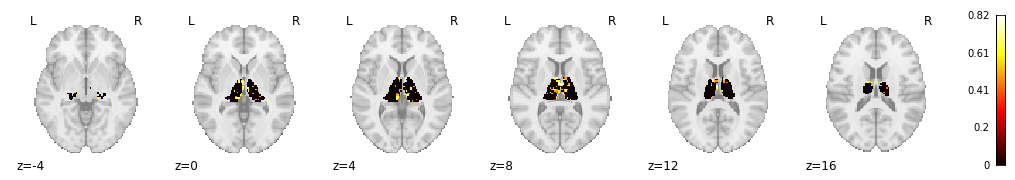

In [ ]:
auditory = ["TimeMov","Rhythm","Harmony","TimeSound","CountTone","SoundRight","SoundLeft","RateDisgustSound","RateNoisy","RateBeautySound","SoundPlace","DailySound","EmotionVoice","MusicCategory","ForeignListen","LanguageSound","AnimalVoice", "FeedbackPos"]
introspection = ["LetterFluency","CategoryFluency","RecallKnowledge","ImagineMove","ImagineIf","RecallFace","ImaginePlace","RecallPast","ImagineFuture"]
motor = ["RateConfidence","RateSleepy","RateTired","EyeMoveHard","EyeMoveEasy","EyeBlink","RestClose","RestOpen","PressOrdHard","PressOrdEasy","PressLR","PressLeft","PressRight"]
memory = ["MemoryNameHard","MemoryNameEasy","MatchNameHard","MatchNameEasy","RelationLogic","CountDot","MatchLetter","MemoryLetter","MatchDigit","MemoryDigit","CalcHard","CalcEasy"]
language = ["RecallTaskHard","RecallTaskEasy","DetectColor","Recipe","TimeValue","DecidePresent","ForeignReadQ","ForeignRead","MoralImpersonal","MoralPersonal","Sarcasm","Metaphor","ForeignListenQ","WordMeaning","RatePoem", "PropLogic"]
visual = ["EmotionFace","Flag","DomesiticName","WorldName","DomesiticPlace","WorldPlace","StateMap","MapIcon","TrafficSign","MirrorImage","DailyPhoto","AnimalPhoto","RateBeautyPic","DecidePeople","ComparePeople","RateHappyPic","RateSexyPicM","DecideFood","RateDeliciousPic","RatePainfulPic","RateDisgustPic","RateSexyPicF","DecideShopping","DetectDifference","DetectTargetPic","CountryMap","Money","Clock","RateBeautyMov","DetectTargetMov","RateHappyMov","RateSexyMovF","RateSexyMovM","RateDeliciousMov","RatePainfulMov","RateDisgustMov"]
groups = [visual, language, memory, motor, introspection, auditory]

task_category = []
for task in TOMOYA_TASKS:
    for i, group in enumerate(groups):
        if task in group:
            task_category.append(i)
            continue

# PC Tomoya
thresholds = [70, 75, 80, 85, 90, 95, 97, 99]
pc_matrix = pc.pc_subject(averaged_sub_beta_tomoya, task_category, thresholds=thresholds)
pc_matrix = np.where(np.isnan(pc_matrix), 0.001, pc_matrix)
pc_matrix = np.where(pc_matrix <= 0, 0.001, pc_matrix)

for i, threshold in enumerate(thresholds):
    pc_img = tomoya_masker.inverse_transform(pc_matrix[:, i])
    plotting.plot_thal(pc_img, vmin=0)
    nib.save(pc_img, TOMOYA_DIR_TREE.analysis_dir + f"pc_{threshold}.nii")


## Activity Flow

In [ ]:
## Tomoya Activity Flow

subjects = base.get_subjects(TOMOYA_DIR_TREE.deconvolve_dir, TOMOYA_DIR_TREE)

tom_avg_cor_array = corr_avg(tomoya_rs, averaged_sub_beta_tomoya, tomoya_cortical_betas, TOMOYA_TASKS)
tom_sub_cor_array = corr_sub(tomoya_rs, tomoya_beta_matrix, tomoya_cortical_betas, TOMOYA_TASKS)

# evoked response to 1
tom_sub_evoked_1 = corr_sub(tomoya_rs, np.ones(tomoya_beta_matrix.shape), tomoya_cortical_betas, TOMOYA_TASKS)
tom_avg_evoked_1 = corr_avg(tomoya_rs, np.ones([tomoya_beta_matrix.shape[0], tomoya_beta_matrix.shape[1]]), tomoya_cortical_betas, TOMOYA_TASKS)

#null
tom_null_corr_array, tom_null_sub_corr_array = null_corr(100, tomoya_beta_matrix, tomoya_cortical_betas, tomoya_rs, TOMOYA_TASKS)

# pca activity flow
tom_comps_task_space_corr = np.zeros([len(TOMOYA_TASKS), 3])
for i in np.arange(3):
    tom_comps_task_space_corr[:, i] = corr_avg(tomoya_rs, np.swapaxes(tomoya_task_space[:, :, i], 0 ,1), tomoya_cortical_betas, TOMOYA_TASKS)


tom_sub_cor_array_80 = corr_sub(tomoya_rs, threshold_matrix(tomoya_beta_matrix, sum_tomoya, 80, 100), tomoya_cortical_betas, TOMOYA_TASKS)
tom_sub_cor_array_60 = corr_sub(tomoya_rs, threshold_matrix(tomoya_beta_matrix, sum_tomoya, 60, 80), tomoya_cortical_betas, TOMOYA_TASKS)
tom_sub_cor_array_40 = corr_sub(tomoya_rs, threshold_matrix(tomoya_beta_matrix, sum_tomoya, 40, 60), tomoya_cortical_betas, TOMOYA_TASKS)
tom_sub_cor_array_20 = corr_sub(tomoya_rs, threshold_matrix(tomoya_beta_matrix, sum_tomoya, 20, 40), tomoya_cortical_betas, TOMOYA_TASKS)
tom_sub_cor_array_0 = corr_sub(tomoya_rs, threshold_matrix(tomoya_beta_matrix, sum_tomoya, 0, 20), tomoya_cortical_betas, TOMOYA_TASKS)

    

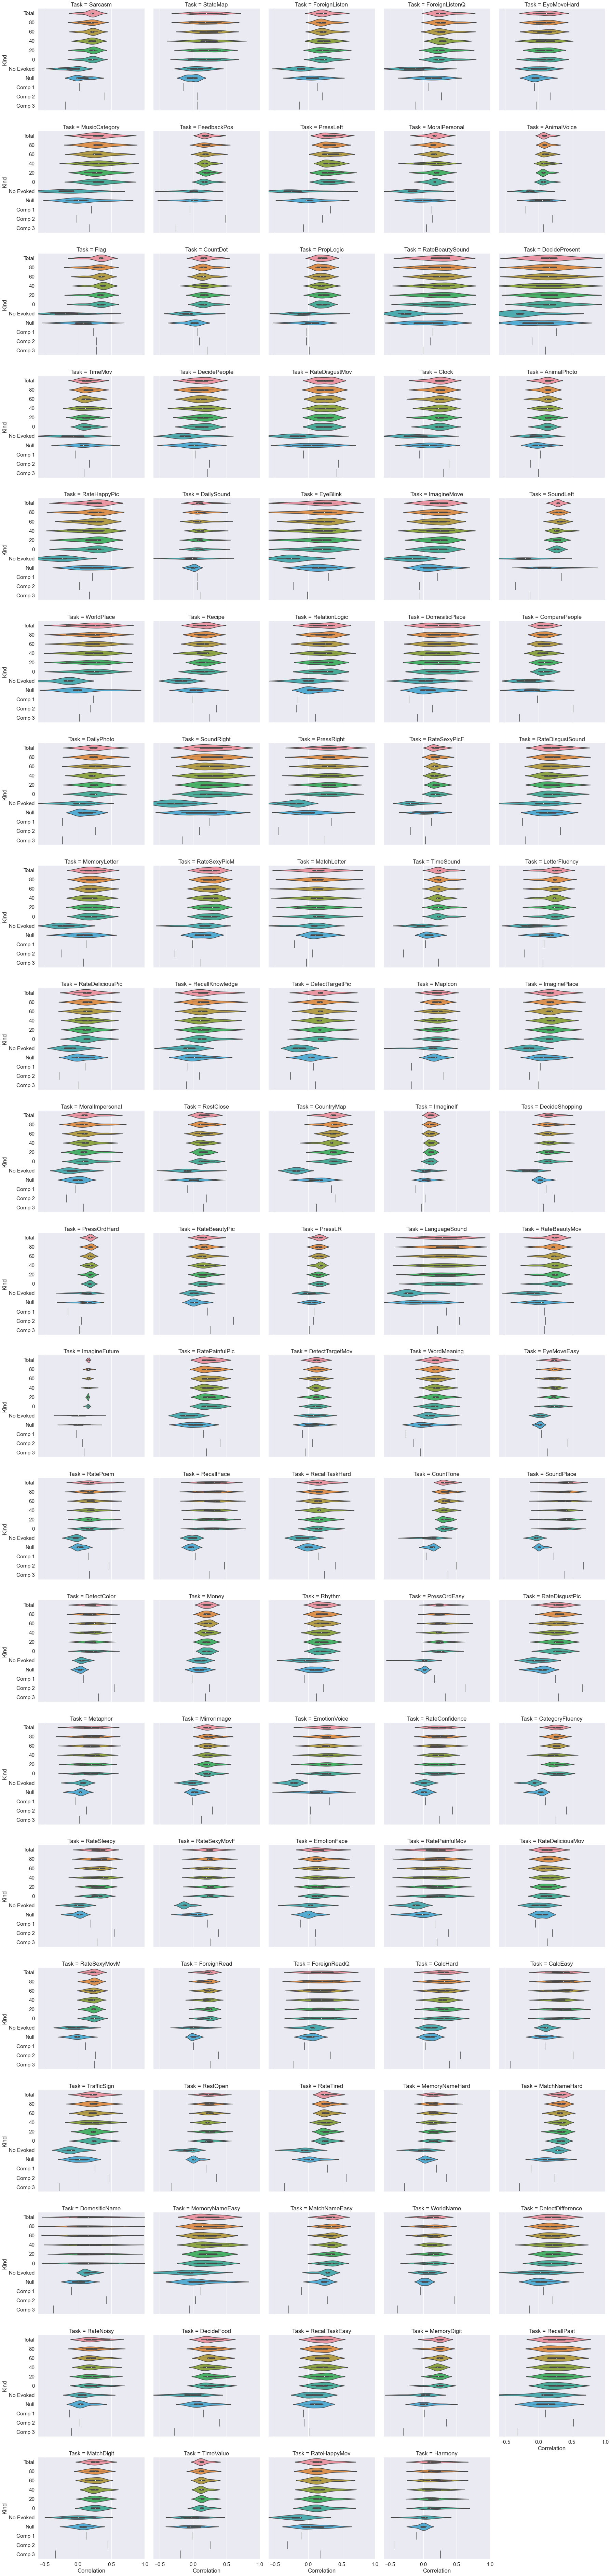

In [ ]:
## Plot Activity flow

# subject correlations
df_rows = []
for i in range(len(TOMOYA_TASKS)):
    for j in range(tom_sub_cor_array.shape[1]):
        df_rows.append([j, TOMOYA_TASKS[i], 'Total', tom_sub_cor_array[i, j]])
        df_rows.append([j, TOMOYA_TASKS[i], '80', tom_sub_cor_array_80[i, j]])
        df_rows.append([j, TOMOYA_TASKS[i], '60', tom_sub_cor_array_60[i, j]])
        df_rows.append([j, TOMOYA_TASKS[i], '40', tom_sub_cor_array_40[i, j]])
        df_rows.append([j, TOMOYA_TASKS[i], '20', tom_sub_cor_array_20[i, j]])
        df_rows.append([j, TOMOYA_TASKS[i], '0', tom_sub_cor_array_0[i, j]])
        df_rows.append([ j, TOMOYA_TASKS[i], 'No Evoked', tom_sub_evoked_1[i, j]])
        df_rows.append([ j, TOMOYA_TASKS[i], 'Null', np.mean(tom_null_sub_corr_array[:, i, j])])
        
    df_rows.append([ 'Avg', TOMOYA_TASKS[i], 'Comp 1', tom_comps_task_space_corr[i, 0]])
    df_rows.append([ 'Avg', TOMOYA_TASKS[i], 'Comp 2', tom_comps_task_space_corr[i, 1]])
    df_rows.append([ 'Avg', TOMOYA_TASKS[i], 'Comp 3', tom_comps_task_space_corr[i, 2]])

df_activity_flow = pd.DataFrame(df_rows, columns=['Subject', 'Task', 'Kind', 'Correlation'])
df_activity_flow.to_pickle(TOMOYA_DIR_TREE.analysis_dir + "mdtb_activity_flow_dataframe.p")


sns.set(font_scale=1.4)
fig = sns.catplot(kind='violin', orient="h", data=df_activity_flow, x='Correlation', y='Kind', col="Task", col_wrap=5)
plt.xlim([-0.6, 1])
plt.xticks([-0.5, 0, .50, 1])

sub_corr_df = pd.DataFrame(np.swapaxes(tom_sub_cor_array, 0, 1), columns=TOMOYA_TASKS)
sub_corr_stats = sub_corr_df.describe()
total_sub_corr_df = pd.DataFrame(tom_sub_cor_array.flatten())
sub_corr_stats['total'] = total_sub_corr_df.describe()
display(HTML(sub_corr_stats.to_html()))
